# Benchmarks
---

Description:
    TBD
---

## First we import python libraries and set up the directory

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [2]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import cost_function
from star_pso.benchmarks.five_uneven_peak_trap import FiveUnevenPeakTrap

In [3]:
# Create a test problem.
benchmark = FiveUnevenPeakTrap()

## Define the multi-objective function

In [4]:
@cost_function(minimize=False)
def func_benchmark(x_array: np.ndarray, **kwargs) -> float:
    # Return the solution.
    return benchmark.func(x_array).item()
# _end_def_

## Here we set the PSO parameters

- Set the number of particles 'N'
- Setup the initial population
- Create the PSO object

In [5]:
# Get an initial sample.
x_sample = benchmark.initial_random_positions(n_pos=80)

# Initial swarm population.
swarm_t0 = Swarm([Particle(x) for x in x_sample])

# Create the StandardPSO object that will carry on the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = func_benchmark,
                       x_min = benchmark.x_min, x_max = benchmark.x_max)

## Optimization process

In [6]:
test_PSO.run(max_it = 2500, f_max_eval = 50_000, verbose = True,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "multimodal"})

Initial f_optimal = 195.6208
Iteration:     1 -> f_optimal = 199.6928
Iteration:   251 -> f_optimal = 200.0000
Iteration:   501 -> f_optimal = 200.0000
StandardPSO Reached the maximum number of function evaluations.
Final f_optimal = 200.0000
run: elapsed time = 8.949 seconds.


In [7]:
# Get the optimal solution from the PSO.
_, _, x_opt = test_PSO.get_optimal_values()

# Compute the final objective functions.
f_opt = benchmark.func(x_opt)

# Print the results.
print(f"x={x_opt.item():.5f}, f(x)={f_opt.item():.5f}")

x=30.00000, f(x)=200.00000


In [8]:
best_n = []

for pt in test_PSO.swarm.best_n(test_PSO.swarm.size):
    best_n.append((pt.position.item(), pt.value))
    
best_n = np.array(best_n)

### Visualize the solution plot

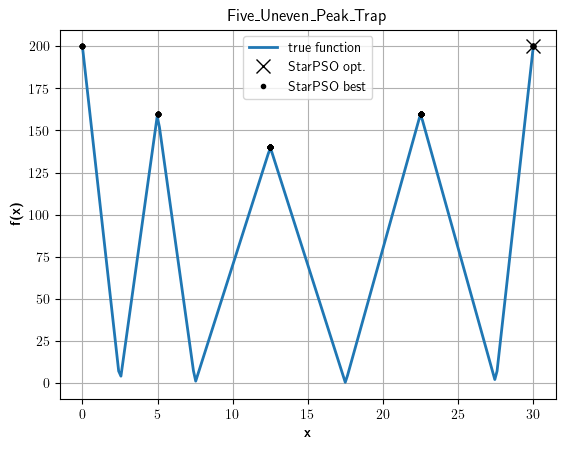

In [9]:
# Set a test range.
x_test = np.linspace(benchmark.x_min,
                     benchmark.x_max,
                     200)
y_test = benchmark.func(x_test)

# Plot the test function.
plt.plot(x_test, y_test, '-', linewidth=2, label="true function")

# Plot the optimal PSO.
plt.plot(x_opt, f_opt, 'kx', markersize=10, label="StarPSO opt.")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "k.", label="StarPSO best")

# Set the x/y labels.
plt.xlabel(r'\textbf{x}')
plt.ylabel(r'\textbf{f(x)}')
plt.title(benchmark.name)

# Final set up.
plt.grid(True)
plt.legend()
plt.show();

### End of file